In [181]:
import pandas as pd
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
from Bio import SeqIO
from Bio.SeqUtils import GC
import scipy.stats as st

sns.set_theme()
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
from Bio.Seq import Seq
from Bio import motifs

# Horizontal transfers

In [206]:
def event_func(path, path_to_tsv):
    file_list = glob.glob((path+'/*_eventCounts.txt'))
    events_frame = pd.DataFrame({'S':[], 'SL':[], 'D':[], 'T':[], 'TL':[], 'L':[], 'Leaf':[], 'Name':[]})
    for file_name in file_list:
        events_frame_og = pd.read_table(file_name, sep=':', header=None, index_col=0).transpose()
        name = os.path.basename(file_name); name = name.split('_')[0]
        events_frame_og['Name'] = [name]
        events_frame = events_frame.append(events_frame_og)
    events_frame.reset_index(drop=True, inplace=True)
    events_frame['AT'] = events_frame['T'] + events_frame['TL']
    
    ortho = pd.read_table('Results/Orthogroups.GeneCount.tsv', sep = '\t')
    ortho_bool = ortho.iloc[:, 1:-1].astype(bool).astype(int)
    ortho_bool["amount"] = ortho_bool.sum(axis=1)
    ortho_bool['Orthogroup'] = ortho['Orthogroup']
    
    amount = [int(ortho_bool[ortho_bool.Orthogroup==i]['amount']) for i in events_frame.Name]
    events_frame['amount'] = amount
    total = [int(ortho[ortho.Orthogroup==i]['Total']) for i in events_frame.Name]
    events_frame['total'] = total
    return events_frame

def make_loc_df(events_frame, path_to_ortho_txt, refGen):
    ortho = pd.read_table(path_to_ortho_txt, sep = ':', header = None)
    ortho = ortho.rename({0: 'og', 1: 'genes'}, axis='columns')

    allTransfers = []
    ogs = []
    start_loc = []
    end_loc = []
    amount = []
    total = []
    genes_list = []
    for og in events_frame.Name:
        genes = ortho[ortho.og == og]['genes'].values[0].split(' ')
        for gene in genes[1:]:
            if gene.split('|')[0] == refGen:
                allTransfers.append(int(events_frame[events_frame.Name == og]['AT']))
                ogs.append(og)
                start_loc.append(int(gene.split('|')[4]))
                end_loc.append(int(gene.split('|')[5]))
                genes_list.append(gene.split('|')[2])
                amount.append(int(events_frame[events_frame.Name == og]['amount']))
                total.append(int(events_frame[events_frame.Name == og]['total']))
    loc_df = pd.DataFrame({'og':ogs, 'gene':genes_list, 'start_loc': start_loc, 'end_loc':end_loc, 'AT':allTransfers, 'amount':amount, 'total': total})
    loc_df.sort_values('start_loc')
    return loc_df

In [207]:
events_frame = event_func("Results/geneRaxResults/reconciliations", 'Results/Orthogroups.GeneCount.tsv')

In [209]:
loc_df_UTI = make_loc_df(events_frame, 'Results/Orthogroups.txt',"GCF_000013265.1_ASM1326v1_genomic")

In [210]:
loc_df_UTI

,og,gene,start_loc,end_loc,AT,amount,total
0,OG0000089,hypothetical_protein,1406568,1406913,10,98,119
1,OG0004178,putative_HTH-type_transcriptional_regulator_YahB,359469,360402,4,98,98
2,OG0002234,hypothetical_protein,2390924,2391974,16,100,100
3,OG0001219,Aldose_1-epimerase,750984,752025,1,100,100
4,OG0004626,hypothetical_protein,6051,7992,4,72,72
...,...,...,...,...,...,...,...
4782,OG0003091,High-affinity_gluconate_transporter,3799427,3800744,4,100,100
4783,OG0004102,Low-affinity_inorganic_phosphate_transporter_1,3345684,3347184,10,99,99
4784,OG0000535,NAD-dependent_methanol_dehydrogenase,2717967,2719155,4,100,101
4785,OG0003974,putative_protein_YdiE,1825199,1825391,0,99,99


# Restriction sites, discontinuity, complexity

In [189]:

def make_reads_frame(path, contig):
    reads = pd.read_table(path, sep = '\t', header = None)
    reads = reads[reads[0] == contig]
    reads = reads.iloc[:, [1,2]]
    reads = reads.rename({1: 'start', 2: 'end'}, axis='columns')
    #add 1 to values because they are written from 0 in the bed file
    reads.loc[:, 'start'] = reads['start'].apply(lambda x: x+1)
    reads.loc[:, 'end'] = reads['end'].apply(lambda x: x+1)
    reads['len'] = reads.end - reads.start
    return reads

def make_depth_frame(path, contig):
    depth_frame = pd.read_table(path, sep = '\t', header = None)
    depth_frame = depth_frame.rename({0: 'gene', 1: 'coordinate', 2: 'depth'}, axis='columns')
    depth_frame = depth_frame[depth_frame['gene']==contig]
    return depth_frame

def make_comp_file(path):
    comp_file_name = glob.glob(path)[0]
    comp = pd.read_table(comp_file_name, sep='\t')
    comp['start'] = comp.position.apply(lambda x : x.split(':')[0])
    comp['start'] = comp['start'].astype(float)
    comp['end'] = comp.position.apply(lambda x : x.split(':')[1])
    comp['end'] = comp['end'].astype(float)
    comp = comp.drop('position', axis=1)
    comp['complexity'] = comp['complexity'].astype(float)
    comp = comp.sort_values('start')
    return comp

def concatenate_frames(comp, depth_frame, reads_frame, record, restriction_sites_frame, window_oversize=9000):
    score_list = []
    GC_list = []
    depth_list = []
    sites_list = []
    reads_max_end = int(reads_frame['end'][-1:])
    comp_max_end = int(comp['end'][-1:])
    max_end = min(reads_max_end,comp_max_end)
    
    for index, row in comp.iterrows():
        start = int(row['start']) - window_oversize if int(row['start']) - window_oversize > 0 else 0
        end = int(row['end']) + window_oversize if int(row['end']) + window_oversize < max_end else max_end
        number = reads_frame[(reads_frame['start'] > start) & (reads_frame['start'] <= end)].shape[0] + reads_frame[(reads_frame['end'] > start) & (reads_frame['end'] <= end)].shape[0]
        depth = depth_frame[(depth_frame.coordinate > start) & (depth_frame.coordinate <= end)]['depth'].mean()
        score_list.append(number/depth)
        GC_list.append(GC(record.seq[start:end]))
        depth_list.append(depth)
        sites_list.append(len(restriction_sites_frame[(restriction_sites_frame.coordinate > start) & (restriction_sites_frame.coordinate <= end)]['coordinate']))
    comp = comp.iloc[0: min(len(comp), len(GC_list)), :]
    comp['score'] = score_list
    comp['GC'] = GC_list
    comp['depth'] = depth_list
    comp['sites'] = sites_list
    return comp

def extend_ambigious_characters(seq):
    D = {'A': 'A', 'C':'C', 'G': 'G', 'T':'T', 'U':'U', 
         'W':'[A|T]', 'S':'[C|G]', 'M': '[A|C]', 'K':'[G|T]', 'R':'[A|G]', 'Y':'[C|T]',
         'B':'[^A]', 'D':'[^C]', 'H':'[^G]', 'V':'[^T|U]',
         'N':'.'
        }
    seq2 = ''
    for i in seq:
        seq2+=D[i]
    return seq2

def make_restriction_sites_frame(seq, patterns):
    coordinates = []
    sites = []
    window = len(max(patterns))
    maxend = len(seq)
    start = 0
    while start+window <= maxend:
        seq_frame = seq[start:start+window]
        #print(seq_frame, max(patterns))
        for pattern in patterns:
            if len(re.findall(pattern, seq_frame)) != 0:
                coordinates.append(start)
                sites.append(pattern)
                start+=window
                break
        else:
            start+=1
    seq = reverse_complement(seq)
    start = 0
    while start+window <= maxend:
        seq_frame = seq[start:start+window]
        #print(seq_frame, max(patterns))
        for pattern in patterns:
            if len(re.findall(pattern, seq_frame)) != 0:
                coordinates.append(maxend-start)
                sites.append(pattern)
                start+=window
                break
        else:
            start+=1
    
    restriction_sites_frame = pd.DataFrame({'sites':sites, 'coordinate':coordinates})
    restriction_sites_frame.sort_values('coordinate')
    return restriction_sites_frame

def reverse_complement(dna):
    complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A',
                 'W':'W', 'S':'S', 'M':'K', 'R':'Y', 'Y':'R',
                 'B':'V', 'D':'H', 'H':'T', 'V':'B'}
    return ''.join([complement[base] for base in dna[::-1]])

# Для UTI_pacbio

In [183]:
reads_UTI_pacbio = make_reads_frame('Results/aln.bed', 'NC_007946.1')
depth_frame_UTI_pacbio = make_depth_frame('Results/depthaln.tsv', 'NC_007946.1')
comp_UTI_pacbio = make_comp_file('Results/gcb_res_window_50/GCF_000013265.1_ASM1326v1_genomic/window_complexity_contig_NC_007946.1.txt')
record_UTI = SeqIO.read('recombinations/GCF_000013265.1_ASM1326v1_genomic.fna', "fasta")

In [187]:
patterns = ['GAGCTC ', 'CACGTG ', 'CGGCCG ', 'CCTNAGG ', 'GGTCTC ', 'CCTNNNNNAGG ', 'TACGTA ', 'RGGNCCY ', 'AGGCCT ', 'GRGCYC ', 'GRGCYC ', 'GAATTC ', 'AGCGCT ', 'ATGCAT ', 'CCWWGG ', 'CCWWGG ', 'CYCGRG ', 'GGTNACC ', 'GGTNACC ', 'GATATC ', 'GATATC ', 'GGWCC ', 'CTGAAG ', 'CTGRAG ', 'CCWGG ']
patterns = [i.rstrip() for i in patterns]
patterns = [extend_ambigious_characters(i) for i in patterns]

In [190]:
restrictions_UTI_pacbio = make_restriction_sites_frame(str(record_UTI.seq), patterns)

In [193]:
compUTI_pacbio = concatenate_frames(comp_UTI_pacbio, depth_frame_UTI_pacbio, reads_UTI_pacbio, record_UTI, restrictions_UTI_pacbio, window_oversize = 15000)

/home/npopov/anaconda3/envs/KolianEn/lib/python3.7/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/npopov/anaconda3/envs/KolianEn/lib/python3.7/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/npopov/anaconda3/envs/KolianEn/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

/home/npopov/anaconda3/envs/KolianEn/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/npopov/anaconda3/envs/KolianEn/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/npopov/anaconda3/envs/KolianEn/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an err

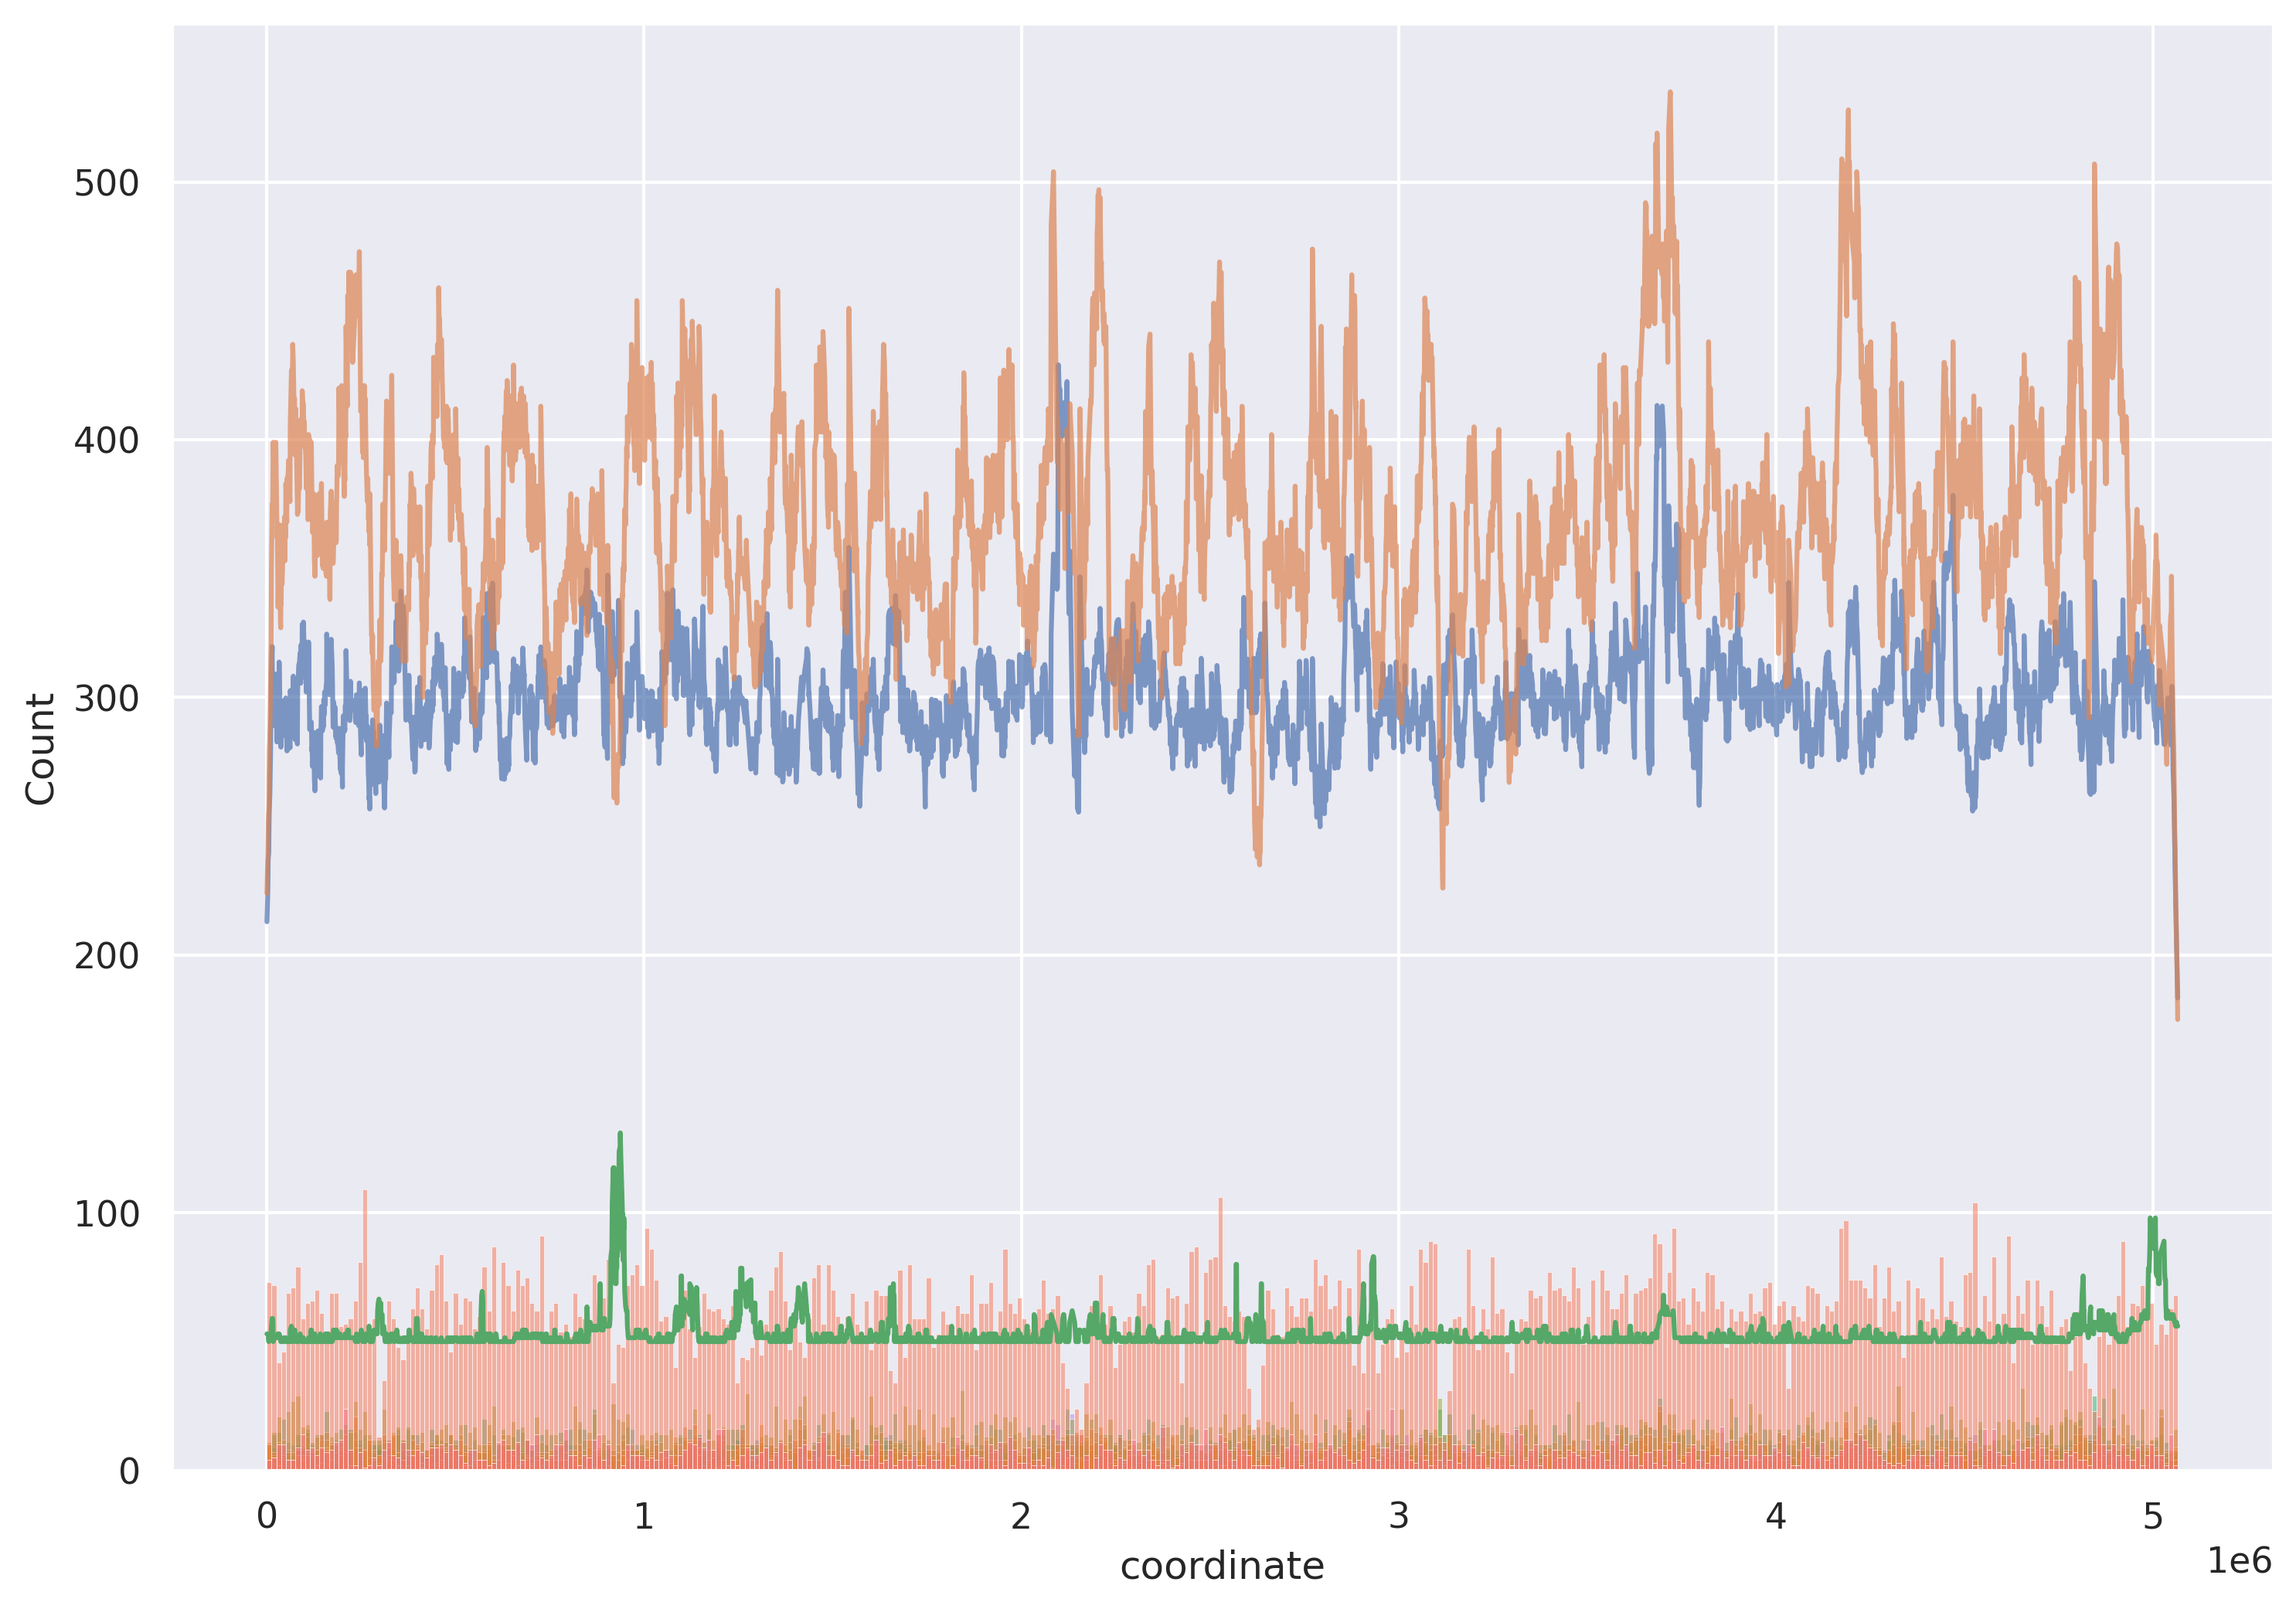

In [202]:
g = sns.histplot(data=restrictions_UTI_pacbio, x='coordinate', hue='sites', bins=400)
sns.lineplot(compUTI_pacbio.start, compUTI_pacbio.score * 40 + 40, alpha = 0.7)
sns.lineplot(compUTI_pacbio.start, compUTI_pacbio.sites, alpha = 0.7)
sns.lineplot(compUTI_pacbio.start, compUTI_pacbio.complexity * 150 + 50)
plt.legend([], [], frameon=False)

In [195]:
compUTI_pacbio.to_csv('Results/comp_with_sites_UTI.csv')

In [196]:
restrictions_UTI_pacbio.to_csv('Results/restriction_sites_frame_UTI.csv')

/home/npopov/anaconda3/envs/KolianEn/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(0.21011209800465558, 1.6108420964215401e-46)

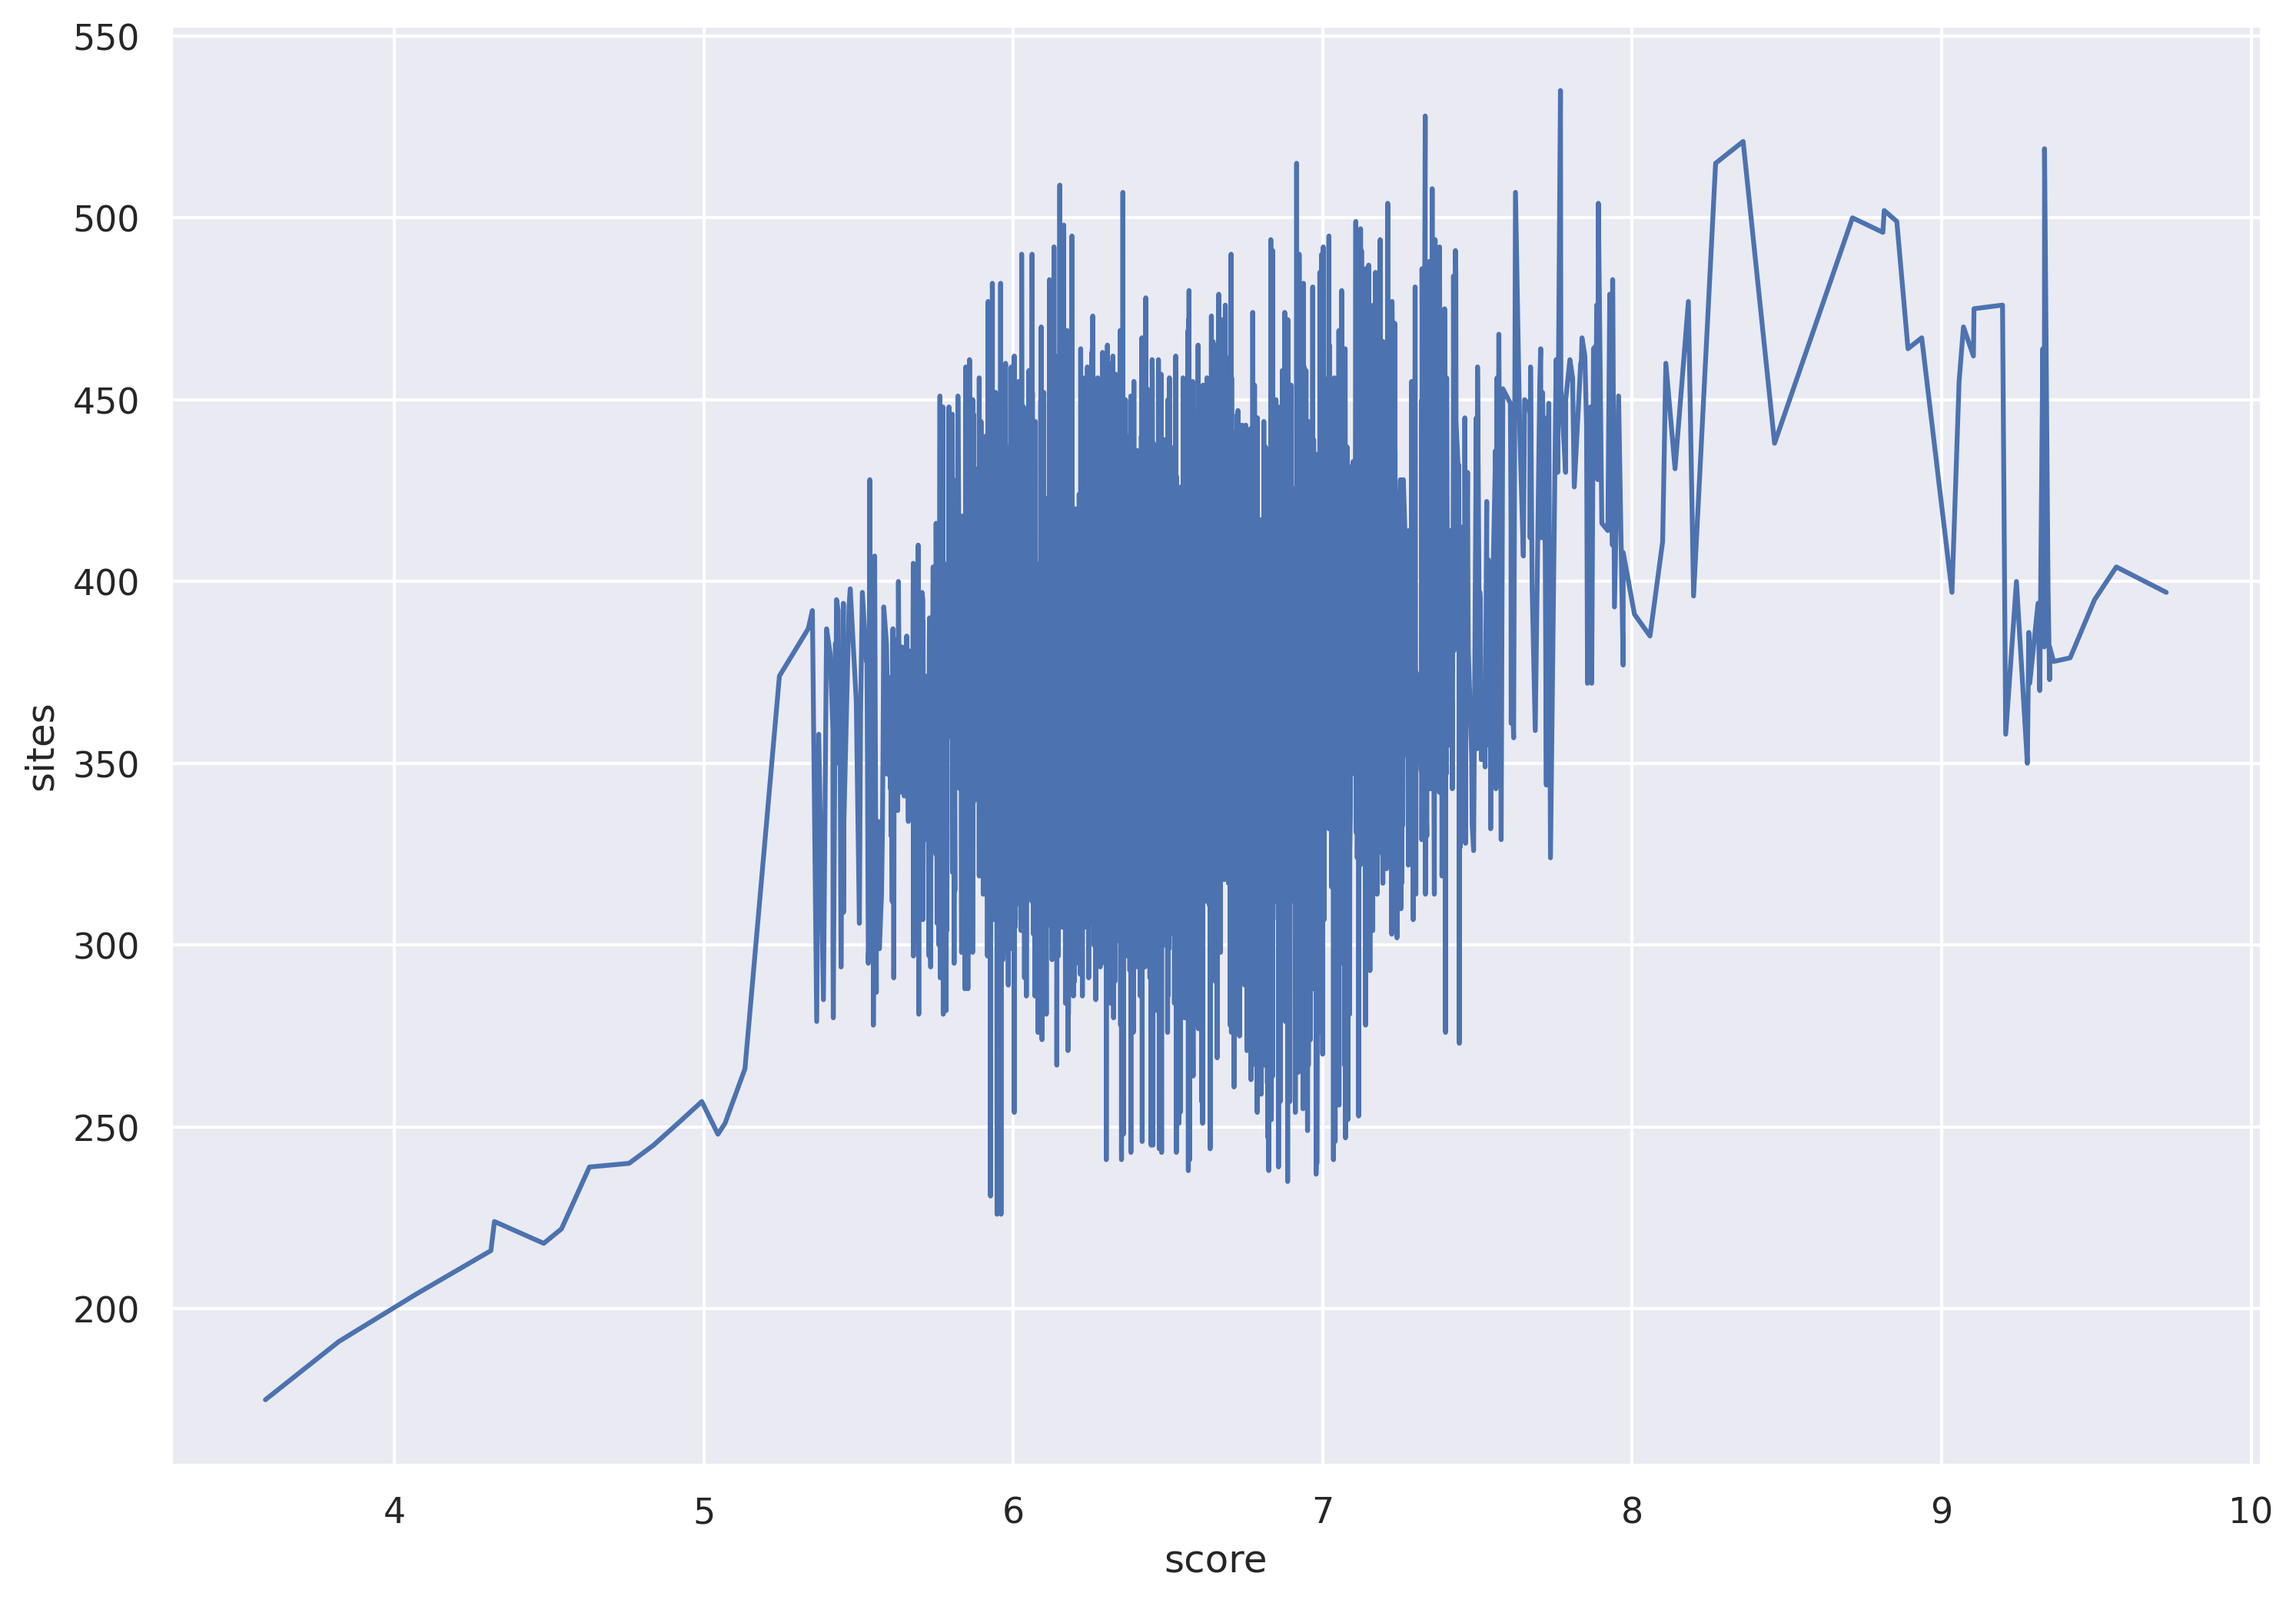

In [203]:
sns.lineplot(compUTI_pacbio.score, compUTI_pacbio.sites)
st.pearsonr(compUTI_pacbio.score, compUTI_pacbio.sites)

# Для LF82 